In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Imputer
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [2]:
data = pd.read_csv('~/Galvanize/analytics-capstone/data/spotify_data.csv')

### Drop Zero Popularity 
There's only ~330 of these

In [3]:
drop_zeros = data[data['popularity'] > 1]

### Split to X and y

In [4]:
X = drop_zeros[['acousticness', 'danceability',
       'duration_ms', 'energy','instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
       'valence']]
y = drop_zeros['popularity']

### Get dummies
Note to self: write this into a function when we move it to a script

In [5]:
keys = pd.get_dummies(X['key'])

In [6]:
X = pd.concat([X, keys], axis=1)

In [7]:
mode = pd.get_dummies(X['mode'])
mode = mode.rename(columns=({0: "is_minor", 1: "is_major"}))
X = pd.concat([X, mode], axis=1)

In [8]:
time_sig = pd.get_dummies(X['time_signature'])
time_sig = time_sig.rename(index = int, columns={1: "time_sig_1", 3: "time_sig_3", 4: "time_sig_4", 5:"time_sig_5"})
X = pd.concat([X, time_sig], axis=1)


### Remove Non-Dummied Categorical Columns
- key, mode, time signature

In [9]:
X = X.drop(['time_signature','mode'], axis=1)

In [10]:
X.shape

(2162, 29)

### Plot Predictors Against Each Other

### Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [12]:
X_train.shape, y_train.shape

((1621, 29), (1621,))

### Test Different Model Types 
- Try: OLS, L1, L2, ElasticNet
- These are R^2 scores with no feature engineering or selection

In [13]:
kf = KFold(10)
scorers = ['r2', 'neg_mean_squared_error']
test_scores = ()
train_scores = ()
test_keys = ['test_r2','test_neg_mean_squared_error']
train_keys = ['train_r2', 'train_neg_mean_squared_error' ]

#normalize data
scalar = StandardScaler()
X_train_std = scalar.fit_transform(X_train)
X_test_std = scalar.fit_transform(X_test)

# OLS 
ols_model = LinearRegression()
ols_scores = cross_validate(ols_model, X_train, y_train, scoring=scorers, cv=kf, return_train_score=True)

#L1 / Lasso
lasso_model = Lasso()
lasso_scores = cross_validate(lasso_model, X_train, y_train, scoring=scorers, cv=kf, return_train_score=True)

#L2 / Ridge
ridge_model = Ridge()
ridge_scores = cross_validate(ridge_model, X_train, y_train, scoring=scorers, cv=kf, return_train_score=True)


#ElasticNet
elastic_model = ElasticNet()
elastic_scores = cross_validate(elastic_model, X_train, y_train, scoring=scorers, cv=kf, return_train_score=True)

list_of_scores = [ols_scores, lasso_scores, ridge_scores, elastic_scores]
for i in list_of_scores: 
    print('test r2: ', i['test_r2'].mean())
    print('train r2', i['train_r2'].mean())
    print('test mse', i['test_neg_mean_squared_error'].mean())
    print('train mse', i['train_neg_mean_squared_error'].mean())
    print(' ')


test r2:  0.2754050784716279
train r2 0.3088058749873967
test mse -504.4968976215158
train mse -484.7816415395704
 
test r2:  0.2158569058158637
train r2 0.22716648900913272
test mse -546.4245962336354
train mse -542.042565522337
 
test r2:  0.2760791217360369
train r2 0.30872961820136197
test mse -503.99425868211875
train mse -484.8350773180652
 
test r2:  0.1935588151902477
train r2 0.2043798967708505
test mse -562.1229023045951
train mse -558.0292147106163
 


### Let's Do Some Feature Selection 
- using SK Learn's [F-Regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)

In [14]:
f, pval = f_regression(X_train_std, y_train)

In [15]:
#f_scores = pd.DataFrame(f, pval)

In [16]:
names = np.asarray(X.columns)
names.shape

(29,)

In [17]:
f_scores = pd.DataFrame(data=[names, f, pval]).transpose().rename(columns={0:'names', 1:'f_score', 2:'p_val'})

In [18]:
f_scores


,names,f_score,p_val
0,acousticness,40.2294,2.92292e-10
1,danceability,33.2673,9.60326e-09
2,duration_ms,126.801,2.25872e-28
3,energy,7.43364,0.00647062
4,instrumentalness,329.919,3.01184e-67
5,key,12.6112,0.00039442
6,liveness,16.0536,6.43666e-05
7,loudness,308.911,1.9991e-63
8,speechiness,1.4704,0.225459
9,tempo,9.41102,0.0021926


The key thing is interesting -- I think it basically matter IF a key is 0, 1, 7 or 11, not which key it ends up being.

### Let's Calculate Multicolinearity 
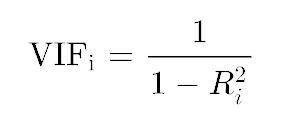

"Analyze the magnitude of multicollinearity by considering the size of the VIF. A rule of thumb is that if VIF >10  then multicollinearity is high" 

"The square root of the variance inflation factor indicates how much larger the standard error is, compared with what it would be if that variable were uncorrelated with the other predictor variables in the model."

In [19]:
X_df = add_constant(X)
pd.Series([variance_inflation_factor(X_df.values, i) 
               for i in range(X_df.shape[1])], 
              index=X_df.columns)

/Users/whitney/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/whitney/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const               0.000000
acousticness        1.553568
danceability        1.551839
duration_ms         1.251978
energy              2.666970
instrumentalness    1.440533
key                      inf
liveness            1.071081
loudness            2.649929
speechiness         1.096102
tempo               1.086762
valence             1.489265
0                        inf
1                        inf
2                        inf
3                        inf
4                        inf
5                        inf
6                        inf
7                        inf
8                        inf
9                        inf
10                       inf
11                       inf
is_minor                 inf
is_major                 inf
time_sig_1               inf
time_sig_3               inf
time_sig_4               inf
time_sig_5               inf
dtype: float64

### Turn Keys from Categorical Across All Keys to Two Types: B, C, E, G or Not

In [20]:
data = pd.read_csv('~/Galvanize/analytics-capstone/data/spotify_data.csv')
drop_zeros = data[data['popularity'] > 1]

X_copy = drop_zeros[['acousticness', 'danceability',
       'duration_ms', 'energy','instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
       'valence']]
y = drop_zeros['popularity']

In [21]:
key_list = [0, 4, 7, 11]
bceg = X_copy['key'].isin(key_list)

In [22]:
X_copy['bceg'] = bceg*1

/Users/whitney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
X_copy = X_copy.drop('key', axis=1)


In [24]:
mode = pd.get_dummies(X_copy['mode'])
mode = mode.rename(columns=({0: "is_minor", 1: "is_major"}))
X_copy = pd.concat([X_copy, mode], axis=1)

In [25]:
time_sig = pd.get_dummies(X_copy['time_signature'])
time_sig = time_sig.rename(index = int, columns={1: "time_sig_1", 3: "time_sig_3", 4: "time_sig_4", 5:"time_sig_5"})
X_copy = pd.concat([X_copy, time_sig], axis=1)


In [26]:
X_copy = X_copy.drop(['time_signature','mode'], axis=1)

In [27]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_copy, y, test_size=0.25)

In [28]:
X_copy_df = add_constant(X_copy)
pd.Series([variance_inflation_factor(X_copy_df.values, i) 
               for i in range(X_copy_df.shape[1])], 
              index=X_copy_df.columns)

/Users/whitney/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/whitney/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const               0.000000
acousticness        1.538916
danceability        1.542014
duration_ms         1.238892
energy              2.651722
instrumentalness    1.427560
liveness            1.064817
loudness            2.633787
speechiness         1.082758
tempo               1.077373
valence             1.484742
bceg                1.007822
is_minor                 inf
is_major                 inf
time_sig_1               inf
time_sig_3               inf
time_sig_4               inf
time_sig_5               inf
dtype: float64

In [29]:
kf = KFold(10)
scorers = ['r2', 'neg_mean_squared_error']

#normalize data
scalar = StandardScaler()
X_train_std2 = scalar.fit_transform(X_train2)
X_test_std2 = scalar.fit_transform(X_test2)

# OLS 
ols_model2 = LinearRegression()
ols_scores2 = cross_validate(ols_model2, X_train2, y_train2, scoring=scorers, cv=kf, return_train_score=True)

#L1 / Lasso
lasso_model2 = Lasso()
lasso_scores2 = cross_validate(lasso_model2, X_train_std2, y_train2, scoring=scorers, cv=kf, return_train_score=True)

#L2 / Ridge
ridge_model2 = Ridge()
ridge_scores2 = cross_validate(ridge_model2, X_train_std2, y_train2, scoring=scorers, cv=kf, return_train_score=True)


#ElasticNet
elastic_model2 = ElasticNet()
elastic_scores2 = cross_validate(elastic_model2, X_train_std2, y_train2, scoring=scorers, cv=kf, return_train_score=True)

list_of_scores = [ols_scores2, lasso_scores2, ridge_scores2, elastic_scores2]
for i in list_of_scores: 
    print('test r2: ', i['test_r2'].mean())
    print('train r2', i['train_r2'].mean())
    print('test mse', i['test_neg_mean_squared_error'].mean())
    print('train mse', i['train_neg_mean_squared_error'].mean())
    print(' ')


test r2:  0.2779077716158651
train r2 0.29656603721404345
test mse -497.87951245369294
train mse -488.2829634654313
 
test r2:  0.26447908790750985
train r2 0.27969576194969176
test mse -507.17544022352433
train mse -499.9913328253313
 
test r2:  0.2779226537711102
train r2 0.2965657907828413
test mse -497.8715157344592
train mse -488.28313457088205
 
test r2:  0.2435578637885687
train r2 0.25583268278282817
test mse -521.9634623415114
train mse -516.5578354708587
 


### Scores increased!

In [30]:
f, pval = f_regression(X_train_std2, y_train2) 

In [31]:
names = np.asarray(X_copy.columns)
names.shape

(17,)

In [32]:
f_scores = pd.DataFrame(data=[names, f, pval]).transpose().rename(columns={0:'names', 1:'f_score', 2:'p_val'})

In [33]:
f_scores

,names,f_score,p_val
0,acousticness,48.4536,4.89646e-12
1,danceability,45.1685,2.49696e-11
2,duration_ms,127.613,1.54591e-28
3,energy,5.18287,0.0229406
4,instrumentalness,307.972,2.97002e-63
5,liveness,16.183,6.01579e-05
6,loudness,304.305,1.39505e-62
7,speechiness,2.76934,0.0962793
8,tempo,9.41843,0.00218381
9,valence,1.58479,0.208254


In [34]:
X_copy.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'bceg', 'is_minor', 'is_major', 'time_sig_1', 'time_sig_3',
       'time_sig_4', 'time_sig_5'],
      dtype='object')

## Let's Go With Only The Best Columns

In [35]:
data = pd.read_csv('~/Galvanize/analytics-capstone/data/spotify_data.csv')
drop_zeros = data[data['popularity'] > 1]

eng_X = drop_zeros[['acousticness', 'danceability',
       'duration_ms', 'energy','instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature',
       'valence']]
y = drop_zeros['popularity']

In [36]:
eng_X = X_copy[['acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness', 'liveness', 'loudness', 'tempo', 'time_sig_3', 'time_sig_4']]
               

In [37]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(eng_X, y, test_size=0.25)


In [43]:
kf = KFold(10)
scorers = ['r2', 'neg_mean_squared_error']

#normalize data
scalar = StandardScaler()
X_train_std3 = scalar.fit_transform(X_train3)
X_test_std3 = scalar.fit_transform(X_test3)

# OLS 
ols_model3 = LinearRegression()
ols_scores3 = cross_validate(ols_model3, X_train3, y_train3, scoring=scorers, cv=kf, return_train_score=True)

#L1 / Lasso
lasso_model3 = Lasso()
lasso_scores3 = cross_validate(lasso_model3, X_train_std3, y_train3, scoring=scorers, cv=kf, return_train_score=True)

#L2 / Ridge
ridge_model3 = Ridge()
ridge_scores3 = cross_validate(ridge_model3, X_train_std3, y_train3, scoring=scorers, cv=kf, return_train_score=True)


#ElasticNet
elastic_model3 = ElasticNet()
elastic_scores3 = cross_validate(elastic_model3, X_train_std3, y_train3, scoring=scorers, cv=kf, return_train_score=True)

list_of_scores = [ols_scores3, lasso_scores3, ridge_scores3, elastic_scores3]
for i in list_of_scores: 
    print('test r2: ', i['test_r2'].max())
    print('train r2', i['train_r2'].max())
    print('test mse', i['test_neg_mean_squared_error'].mean())
    print('train mse', i['train_neg_mean_squared_error'].mean())
    print(' ')


test r2:  0.31017469659581176
train r2 0.26733445892233176
test mse -521.57350613925
train mse -515.1578480148127
 
test r2:  0.28000393888976305
train r2 0.2536875572965077
test mse -529.662178447384
train mse -524.5274387742983
 
test r2:  0.31012593904192587
train r2 0.267334069137813
test mse -521.5658266017547
train mse -515.1580936758639
 
test r2:  0.24404549240627693
train r2 0.22627036477199558
test mse -546.7408328885408
train mse -543.0276767814546
 


### Scores Went Up Again

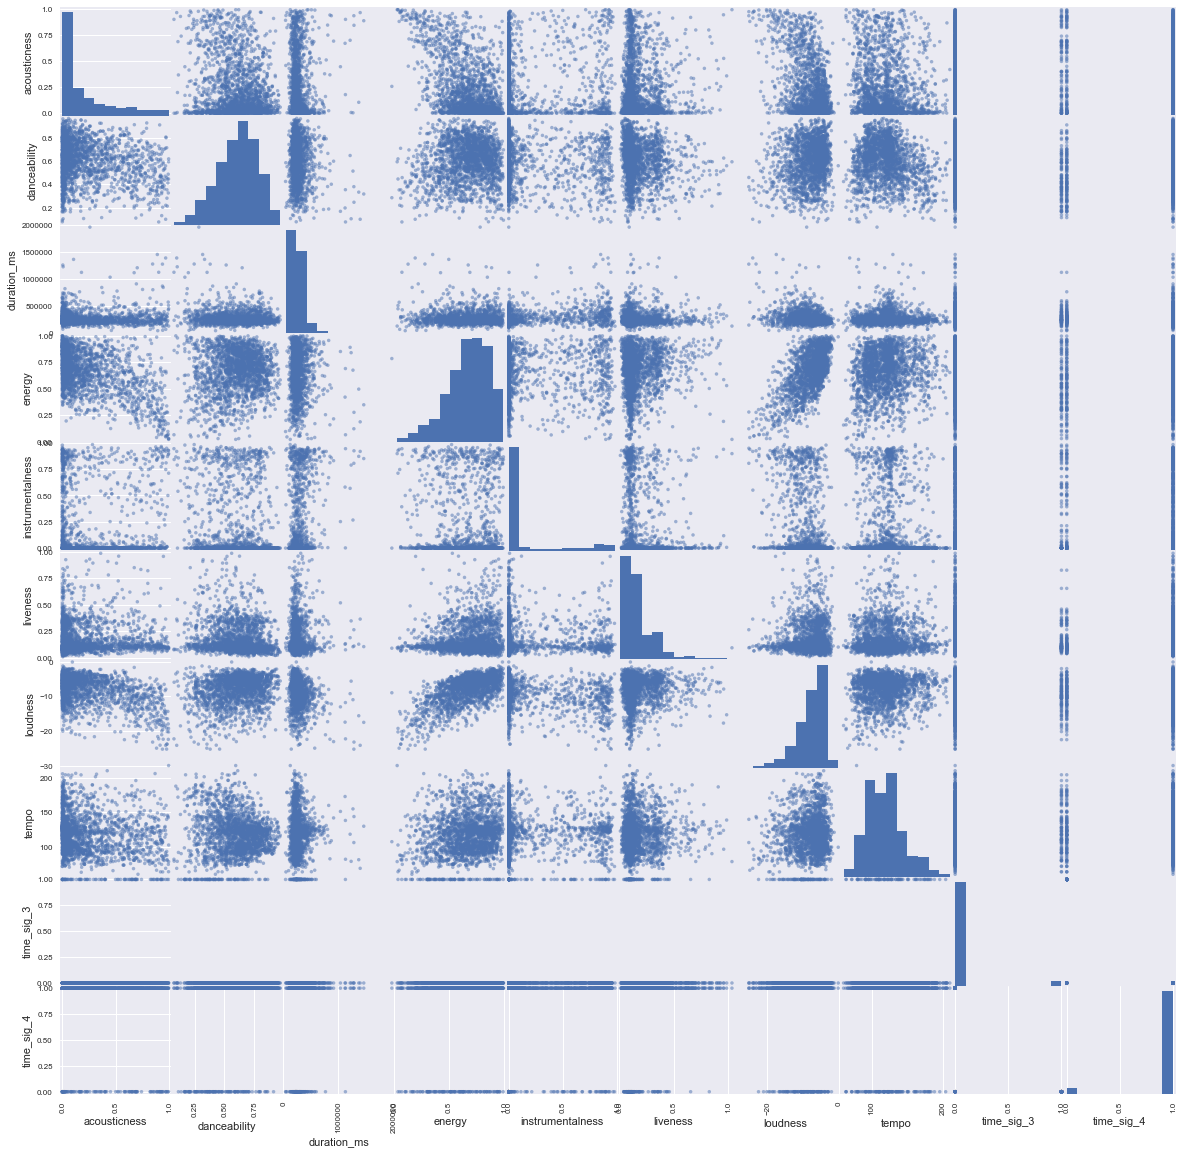

In [39]:
pd.plotting.scatter_matrix(eng_X, figsize=(20,20))
plt.savefig("scatter_matrix")
plt.show()

### Find Colinearity 

In [40]:
type(eng_X)
eng_X.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'tempo', 'time_sig_3',
       'time_sig_4'],
      dtype='object')

In [41]:
vif_df = add_constant(eng_X)

In [42]:
pd.Series([variance_inflation_factor(vif_df.values, i) 
               for i in range(vif_df.shape[1])], 
              index=vif_df.columns)

const               166.929022
acousticness          1.505346
danceability          1.185561
duration_ms           1.222989
energy                2.225718
instrumentalness      1.385100
liveness              1.053014
loudness              2.477664
tempo                 1.070966
time_sig_3            3.790565
time_sig_4            3.825251
dtype: float64

### Predicted Probability vs. Actual Probability For OLS

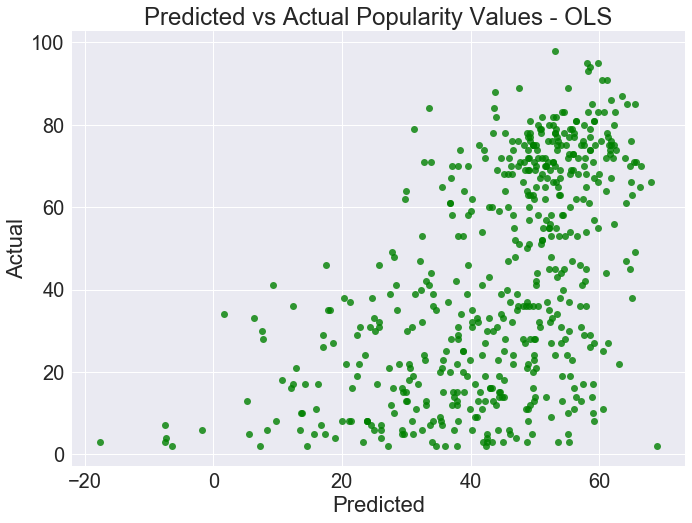

In [69]:
ols_model3 = LinearRegression()
ols_model3.fit(X, y)
predictions = ols_model3.predict(X_test)

sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.regplot(predictions, y_test, fit_reg=False, color="green")
ax.set_title('Predicted vs Actual Popularity Values - OLS')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.savefig('Predict_vs_Actual.png')
